In [39]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
colors = sns.color_palette('colorblind')

# UNDERSTAND EXP3 ALGORITHM

## Pseudo-Regret

The **pseudo-regret** $\bar{R_n}$ after $n$ rounds measures the difference between the expected cumulative loss of the algorithm and that of the best fixed arm in hindsight:

$$
\bar{R_n} = \mathbb{E} \left[ \sum_{t=1}^n \ell_{I_t, t} \right] - \min_{i \in \{1, ..., K\}} \mathbb{E} \left[ \sum_{t=1}^n \ell_{i,t} \right]
$$

A small pseudo-regret means the algorithm performs nearly as well as the best fixed arm in retrospect.

## Exp3 Algorithm (Exponential weights for Exploration and Exploitation)

**Parameter:** a non-increasing sequence of real numbers $(\eta_t)_{t \in \mathbb{N}}$.  
Let $p_1$ be the uniform distribution over $\{1, ..., K\}$.

For each round $t = 1, 2, ..., n$:
1. Draw an arm $I_t$ according to the probability distribution $p_t$.
2. For each arm $i = 1, ..., K$, compute the estimated loss:
   $$
   \hat{\ell}_{i,t} =
   \begin{cases}
   \dfrac{\ell_{i,t}}{p_{i,t}} & \text{if } I_t = i \\
   0 & \text{otherwise}
   \end{cases}
   $$
   and update the estimated cumulative loss:
   $$
   L_{i,t} = L_{i,t-1} + \hat{\ell}_{i,t}
   $$
3. Update the probability distribution over the arms:
   $$
   p_{i,t+1} = \frac{\exp(-\eta_t L_{i,t})}{\sum_{k=1}^{K} \exp(-\eta_t L_{k,t})}
   $$


In [58]:
class Exp3:
    def __init__(self):
        self.K = 10              #NUMBER OF ARMS
        self.EPS = 1e-8          #DO NOT DIVIDE BY 0
        self.T = 1_000           #HORIZON
        self.nb_episodes = 10    #NB_EPISODES
        self.reset()     

    def reset(self):
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.L = np.zeros(self.K)
        self.environment_observe_losses = np.zeros(self.K)  #TO COMPUTE PSEUDO-REGRET
        self.incurred_loss = 0

    def compute_loss(self, k):
        """ Simulating the environment """
        for i in range(self.K):
            mean = i / self.K
            loss_i = np.random.normal(mean, 0.2)
            self.environment_observe_losses[i] += loss_i
            if k==i:
                loss = loss_i
                self.incurred_loss += loss_i
        return loss

    def perform_experiment(self):
        regrets = np.zeros((self.nb_episodes, self.T))
        for ep in range(self.nb_episodes):
            self.reset()
            for t in tqdm(range(self.T)):
                eta_t = np.sqrt(2*np.log(self.K)/self.T*self.K)  #DEFINE ETA
                I_t = np.random.choice(range(self.K), p=self.p)  #DRAW I_t
                l_t = self.compute_loss(I_t)                     #OBSERVE LOSS l_t
                l_hat = l_t / (self.p[I_t] + self.EPS)           #COMPUTE THE UNBIASED ESTIMATOR
                self.L[I_t] += l_hat                             #UPDATE THE LOSS VECTOR

                #UPDATE THE WEIGHTS
                weights = np.exp(-eta_t * self.L)
                self.p = weights / np.sum(weights)

                #THEN COMPUTE THE PSEUDO-REGRET
                best_arm = np.argmin(
                                self.environment_observe_losses) #ARM WITH LOWEST CUMULATIVE LOSS
                PSEUDO_REGRET_t = self.incurred_loss - self.environment_observe_losses[best_arm]
                regrets[ep, t] = PSEUDO_REGRET_t

        #PLOTTING THE CUMULATIVE PSEUDO-REGRET 
        reg_plot = plt.figure()
        mean_reg = np.mean(regrets, axis=0)
        q=10
        q_reg = np.percentile(regrets, q, axis=0)
        Q_reg = np.percentile(regrets, 100-q, axis=0)
        plt.plot(np.arange(self.T), mean_reg, label="Exp3 Pseudo-Regret")
        #plt.plot(np.arange(self.T), [np.sqrt(2*self.T*self.K*np.log(self.K))]*self.T, label="PSEUDO-REGRET Bound")
        plt.fill_between(np.arange(self.T), q_reg, Q_reg, alpha=0.2)
        plt.xlabel('time steps')
        plt.ylabel('Cumulative Regret')
        plt.legend()
        reg_plot.show()


100%|██████████| 1000/1000 [00:00<00:00, 44199.42it/s]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_16081/1632063215.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


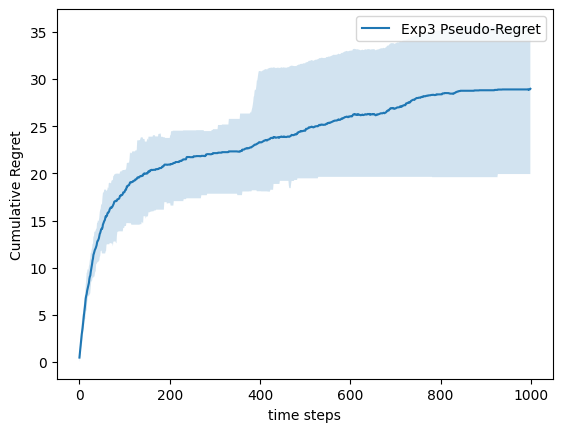

In [59]:
exp3 = Exp3()
exp3.perform_experiment()